In [14]:
#Load edges and nodes

import numpy as np
from load_data import *

nodes_array, edge_array = assert_edges_are_within_first_cluster()

node_lookup_dict = {}

min_index = np.amin(nodes_array)
max_index = np.amax(nodes_array)


for node in nodes_array:
    node_lookup_dict[node] = 1
    
    
data_dir = '../data/'

98753it [00:00, 1000164.45it/s]
2004it [00:00, 1284637.81it/s]


In [16]:
#Get dois from the exosome csv
#Read the DOIS from the node id

from load_data import *

import csv

csv_file_path = data_dir + 'exosome.csv'

# Open the CSV file for reading
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    dois = {}
    for line_number, row in tqdm(enumerate(csv_reader), total = 14695476):  # 'total' is the total number of iterations
        
        if line_number <min_index or line_number > max_index:
            continue
            
        id = int(row[0])
        doi = row[2]
        
        if id in node_lookup_dict:
            node_lookup_dict[id] = doi



100%|██████████| 14695476/14695476 [00:32<00:00, 456963.81it/s]


In [17]:
#Save
import json

with open('first_cluster_dois.json', 'w') as json_file:
    json.dump(node_lookup_dict, json_file, indent=4)
    


In [18]:
#Get PMID by doi

import requests
import xmltodict

doi_dict = {}

#Get dois
def fetch_pmid_from_doi(doi='10.1073/pnas.0510928103'):

    pmid_dict = {}
    request_str = 'https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?tool=my_tool&email=my_email@example.com&ids='
    request_str += str(doi)
    
    response = requests.get(request_str)
    response_text = response.text
    
    if response.status_code == 200:
        index = response_text.index('pmid=')


        pmid_whole = response_text[index:].split(' ')[0]
        pmid = int(pmid_whole[:-1].split('\"')[1])

        return pmid
    
    else:
        return 0
    

for key in tqdm(node_lookup_dict.keys()):
    doi_dict[key] = fetch_pmid_from_doi(key)
    

100%|██████████| 2004/2004 [04:18<00:00,  7.75it/s]


In [19]:
#It turns out that initial node ids is their PMID


for key, value in doi_dict.items():
    assert key == value
    

with open('first_cluster_pmid.json', 'w') as json_file:
    json.dump(doi_dict, json_file, indent=4)
    

In [20]:
import json

with open('first_cluster_pmid.json', 'r') as json_file:
    doi_dict = json.load(json_file)
    
pmid_dict = doi_dict

In [ ]:
#Save all xmls
all_xmls = {}
def save_all_xmls(pmid):
    wait = 0.25
    time.sleep(wait)
    pmid_dict = {}
    request_str  = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id='
    request_str += str(pmid)
    
    response = requests.get(request_str)
    response_text = response.text
    
    try:
        xml_dict = xmltodict.parse(response_text)
        
    except:
        time.sleep(2 * wait)
        return fetch_metadata_from_pmid(pmid)
    
    return response_text

for id in tqdm(pmid_dict):
    all_xmls[id] = save_all_xmls(id)

with open('first_cluster_xmls.json', 'w') as json_file:
    json.dump(all_xmls, json_file, indent=4)
    




In [22]:
#Load all XMLs
import json

with open('first_cluster_xmls.json', 'r') as json_file:
    all_xmls = json.load(json_file)

In [53]:
#Mispelled
import time
import requests
import xmltodict

parsed_error = []
dict_of_interest = {'keyword': 0, "grant": 0, "abstract": 0, "mesh": 0, "chemicallist":0, 'datecompleted': 0}


def fetch_metadata_from_pmid(response_text, idx, pmid): 
    global dict_of_interest
    mesh_headings = []
    grants = []
    year = ""
    journal_ISSN = ""
    abstract = ""
    chemical_list = []
    meta_data = {}
    
    try:
        xml_dict = xmltodict.parse(response_text)
        
        for key_of_interest in dict_of_interest.keys():
            if key_of_interest in str(xml_dict).lower():

                dict_of_interest[key_of_interest] += 1

        #Date completed or revised?
        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation'].keys())
        
        
        try:
            if 'DateCompleted' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
                if 'Year' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['DateCompleted']:
                    year = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['DateCompleted']['Year']

            else:
    #             print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation'])
                  pass
    
        except:
            pass


        
        try:
            
            if 'ISSN' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal'].keys():
                journal_ISSN = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Journal']['ISSN']['#text']
        
        except:
            pass
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']))
        
        
        #Grant
        #Very few grants don't have grant id's
        #Grant institute could also be relevant
        #TODO: collect missing grant id

        try:
            if 'GrantList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']:
                for grant in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant']:
                    if 'GrantID' in grant and 'Agency' in grant:
                        grants.append((grant['GrantID'],grant['Agency']))
                        
        except:
            pass
        
        
        try:
            
            if 'Abstract' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article'].keys():
                if 'AbstractText'  in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Abstract'].keys():
                    abstract = xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['Abstract']['AbstractText']
        except:
            pass
        
 

        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['Article']['GrantList']['Grant'][0])
        
        #MeSH heading  
        
        try:
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']))
        
            #DescriptorName? Is a term
            if 'MeshHeadingList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
                for mesh in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']:
    #                 print(mesh['DescriptorName'])
    #                 print(mesh['DescriptorName']['@UI'])
    #                 print(mesh['DescriptorName']['#text'])
                    mesh_headings.append((mesh['DescriptorName']['@UI'], mesh['DescriptorName']['#text']))
        except:
            pass
        
        
        try:
        #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']))
        
            #DescriptorName? Is a term
            if 'ChemicalList' in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']:
#                print(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']
# #                      ['ChemicalList']['Chemical']['NameOfSubstance'])
               #print(len(xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']))
               for substance in xml_dict['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['ChemicalList']['Chemical']:
                        chemical_list.append(substance['NameOfSubstance']['@UI'])
                #print(chemical_list)
                
               
              

        except:
            pass
        


        #References and history
        #print(xml_dict['PubmedArticleSet']['PubmedArticle']['PubmedData'].keys())


    except:
        parsed_error.append(idx)
        pass


 
        
    meta_data = {'mesh': mesh_headings, 'grants': grants, 'year': year, 'journal': journal_ISSN, 'abstract': abstract }
        
    return meta_data

metadata_dict = {}

# [166, 719, 1672, 1918] odd

idx = 0
for key, value in tqdm(all_xmls.items()):
    metadata_dict[key] = fetch_metadata_from_pmid(value, idx, key)
    idx += 1
    


print(f'failed parse {len(parsed_error)}')
print(f'Occured keyword dict: {dict_of_interest}')

100%|██████████| 2004/2004 [00:03<00:00, 529.26it/s]

failed parse 4
Occured keyword dict: {'keyword': 19, 'grant': 139, 'abstract': 961, 'mesh': 1986, 'chemicallist': 1084, 'datecompleted': 1987}


In [50]:
#### Count incomplete data

features = {'mesh': 0, 'grants': 0, 'year': 0, 'journal': 0, 'abstract': 0}
#Mesh terms are sometimes unrelated

mesh_length = []

for feature in features.keys():
    for _, meta in metadata_dict.items():
        if len(meta[feature]) > 0:
            features[feature] += 1
            if feature == 'mesh':
                mesh_length.append(len(meta[feature]))
            
print("Ocurred features ", features)
print("avg mesh length ", np.mean(mesh_length))


Ocurred features  {'mesh': 1978, 'grants': 57, 'year': 1987, 'journal': 1956, 'abstract': 852}
avg mesh length  9.54954499494439


In [51]:
import json

with open('first_cluster_metadata.json', 'w') as json_file:
    json.dump(metadata_dict, json_file, indent=4)
    


In [79]:
import matplotlib.pyplot as plt


def report_stats(vals, title):
    median = np.median(vals)
    mean = np.mean(vals)
    min = np.amin(vals)
    max = np.amax(vals)
    total = np.sum(vals)
    
    fig = plt.figure(figsize=(10, 7))
#     fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)
    ax.boxplot(vals)
    
    labels = [title]

    ax.set_xticklabels(labels)

    ax.set_title(f'{title}  boxplot diagram')
#     ax.set_xlabel(f'{title}')
    ax.set_ylabel('Values')

    plt.show()


    print(f'median {median} mean {mean} min {min} max {max}, total {total}')

    

def calculate_distance_matrix(feature):
    distance_matrix = np.zeros((len(nodes_array), len(nodes_array))) 
    
    if feature == 'year':
        for i in tqdm(range(distance_matrix.shape[0])):
            for j in range(i):
                pmid1 = str(nodes_array[i])
                pmid2 = str(nodes_array[j])
                
                year1 = metadata_dict[pmid1][feature]
                year2 = metadata_dict[pmid2][feature]
                
                if len(year1) > 0 and len(year2)>0:
                    distance_matrix[i][j]= np.abs(int(year1)-int(year2))
                
                else:
                    distance_matrix[i][j]= -1
        
        distance_matrix = distance_matrix + distance_matrix.transpose()
        return distance_matrix

year_distance_matrix = calculate_distance_matrix('year')
np.save('year_distance_matrix.npy', year_distance_matrix)


100%|██████████| 2004/2004 [00:05<00:00, 350.88it/s]


In [81]:
cocitation_matrix = np.load('cocitation_matrix.npy')
bib_coupling_matrix = np.load('bib_coupling_matrix.npy')


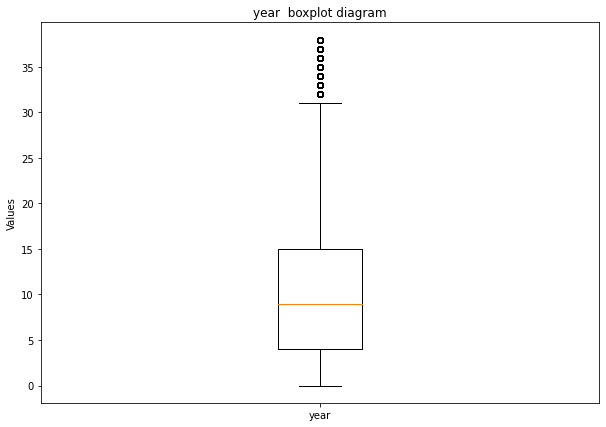

median 9.0 mean 9.887300687094513 min 0.0 max 38.0, total 19508544.0


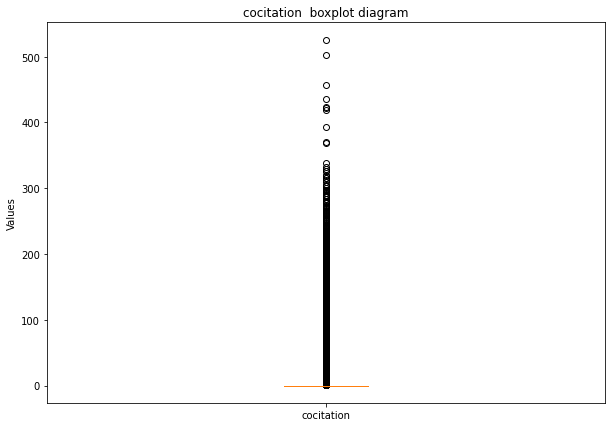

median 0.0 mean 1.5987964161542119 min 0.0 max 526.0, total 3208794.0


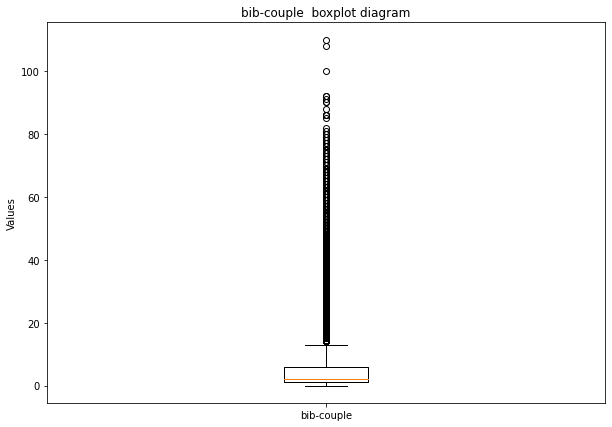

median 2.0 mean 4.4568461678739375 min 0.0 max 110.0, total 8944917.0


In [83]:
#Assuming a square matrix, report statistics
def report_matrix_stats(matrix, title):
    n = matrix.shape[0]
    all_values = []
    
    for i in range(n):
        for j in range(i):
            #Remove negatives as they are flags
            if matrix[i][j] > -1:
                all_values.append(matrix[i][j])
    
    report_stats(all_values, title)
    
    
report_matrix_stats(year_distance_matrix, 'year')
report_matrix_stats(cocitation_matrix, 'cocitation')
report_matrix_stats(bib_coupling_matrix, 'bib-couple')